In [1]:
#!gsutil cp gs://asxc_users/Yaniv/AffectNet.zip .

Copying gs://asxc_users/Yaniv/AffectNet.zip...
\ [1 files][324.4 MiB/324.4 MiB]                                                
Operation completed over 1 objects/324.4 MiB.                                    


In [9]:
!gsutil cp gs://asxc_users/Yaniv/FERPlus-master.zip .

Copying gs://asxc_users/Yaniv/FERPlus-master.zip...
/ [1 files][534.0 KiB/534.0 KiB]                                                
Operation completed over 1 objects/534.0 KiB.                                    


In [26]:
!pwd


/home/jupyter/AffectNet_model_training


In [1]:



def safe_copy(src, dst):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy2(src, dst)


def split_dataset():
    source = Path(SOURCE_DIR)
    target = Path(TARGET_DIR)

    print(f"[INFO] Splitting dataset from: {source.resolve()}")
    print(f"[INFO] Into: {target.resolve()}")
    target.mkdir(parents=True, exist_ok=True)

    for split in ["train", "val", "test"]:
        (target / split).mkdir(parents=True, exist_ok=True)

    for cls in CLASS_NAMES:
        print(f"\n[INFO] Processing class: {cls}")
        src_cls_dir = source / cls

        if not src_cls_dir.exists():
            print(f"[WARNING] Class folder not found: {src_cls_dir}")
            continue

        images = [x for x in src_cls_dir.iterdir() if x.suffix.lower() in [".jpg",".png",".jpeg"]]
        print(f"[INFO] Found {len(images)} images")

        # ---------------- SPLIT ----------------
        train_files, temp_files = train_test_split(
            images, test_size=(1 - TRAIN_RATIO), random_state=42
        )
        rel_test = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
        val_files, test_files = train_test_split(
            temp_files, test_size=rel_test, random_state=42
        )

        print(f" → Train: {len(train_files)}")
        print(f" → Val:   {len(val_files)}")
        print(f" → Test:  {len(test_files)}")

        # ---------------- COPY -----------------
        for f in train_files:
            safe_copy(f, target / "train" / cls / f.name)

        for f in val_files:
            safe_copy(f, target / "val" / cls / f.name)

        for f in test_files:
            safe_copy(f, target / "test" / cls / f.name)

    print("\n[SUCCESS] Dataset has been split successfully!")
    print(f"Train/Val/Test saved in: {TARGET_DIR}")

import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

# ========= Configure ==========
#
SOURCE_DIR = "AffectNet/data"            # where the emotion folders are
TARGET_DIR = "AffectNet/data_split"      # output folder

CLASS_NAMES = ['anger','disgust','fear','happy','sad','surprise','neutral']

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15
# (must sum to 1.0)

# ==============================
# Run the splitter
split_dataset()


[INFO] Splitting dataset from: /home/jupyter/AffectNet_model_training/AffectNet/data
[INFO] Into: /home/jupyter/AffectNet_model_training/AffectNet/data_split

[INFO] Processing class: anger
[INFO] Found 3218 images
 → Train: 2252
 → Val:   483
 → Test:  483

[INFO] Processing class: disgust
[INFO] Found 2477 images
 → Train: 1733
 → Val:   372
 → Test:  372

[INFO] Processing class: fear
[INFO] Found 3176 images
 → Train: 2223
 → Val:   476
 → Test:  477

[INFO] Processing class: happy
[INFO] Found 5044 images
 → Train: 3530
 → Val:   757
 → Test:  757

[INFO] Processing class: sad
[INFO] Found 3091 images
 → Train: 2163
 → Val:   464
 → Test:  464

[INFO] Processing class: surprise
[INFO] Found 4039 images
 → Train: 2827
 → Val:   606
 → Test:  606

[INFO] Processing class: neutral
[INFO] Found 5126 images
 → Train: 3588
 → Val:   769
 → Test:  769

[SUCCESS] Dataset has been split successfully!
Train/Val/Test saved in: AffectNet/data_split


AffectNet	 AffectNet.zip	FERPlus-master.zip  RAF-DB.zip	processed_faces
AffectNet.ipynb  FERPlus	RAF-DB		    data_split


In [2]:
#!unzip AffectNet.zip 

In [22]:
#!pip install mediapipe opencv-python

In [23]:
#!pip install "numpy<2.0.0,>=1.23.5" "ml-dtypes>=0.3.1,<0.5.0" --force-reinstall

In [2]:
import os
import math
import time
import itertools
from pathlib import Path
from collections import Counter

import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report

# ============================================================
# CONFIG
# ============================================================

RAW_DATA_DIR = "AffectNet/data_split"          # with train/val/test subdirs
PROCESSED_DATA_DIR = "AffectNet/processed_faces"

IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 7
CLASS_NAMES = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

EPOCHS_FROZEN = 10
EPOCHS_FT = 20

USE_LABEL_SMOOTHING = True
LABEL_SMOOTHING_ALPHA = 0.1

USE_FOCAL_LOSS = False   # extra trick (turn on if you want)
FOCAL_GAMMA = 2.0
FOCAL_ALPHA = 0.25

BACKBONE_TRAINABLE_LAYERS = 60  # how many last layers to unfreeze in fine-tuning

# ============================================================
# 3. PREPROCESSING: FACE DETECTION + ALIGNMENT (MEDIAPIPE)
# ============================================================

mp_face = mp.solutions.face_detection


2025-11-21 14:22:27.827787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-21 14:22:27.847821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-21 14:22:27.853998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-21 14:22:27.870070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:

# ============================================================
# 3. PREPROCESSING: FACE DETECTION + ALIGNMENT (MEDIAPIPE)
# ============================================================

mp_face = mp.solutions.face_detection


def detect_face_mediapipe(image, detector):
    """
    Detects a face using Mediapipe.
    Returns: (x, y, bw, bh), left_eye, right_eye OR None if no face.
    """
    h, w = image.shape[:2]
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = detector.process(rgb)

    if not results.detections:
        return None

    det = results.detections[0]
    bbox = det.location_data.relative_bounding_box

    x = int(bbox.xmin * w)
    y = int(bbox.ymin * h)
    bw = int(bbox.width * w)
    bh = int(bbox.height * h)

    keypoints = det.location_data.relative_keypoints
    # 0: right eye, 1: left eye usually, but we keep naming consistent: left_eye, right_eye
    right_eye_kp = keypoints[0]
    left_eye_kp = keypoints[1]

    left_eye = (int(left_eye_kp.x * w), int(left_eye_kp.y * h))
    right_eye = (int(right_eye_kp.x * w), int(right_eye_kp.y * h))

    return (x, y, bw, bh), left_eye, right_eye


def detect_and_align_face(image, detector, desired_size=IMG_SIZE, margin=0.2):
    """
    Detect + align + crop face to desired_size x desired_size.
    Returns face image or None.
    """
    h, w = image.shape[:2]
    det = detect_face_mediapipe(image, detector)
    if det is None:
        return None

    (x, y, bw, bh), left_eye, right_eye = det

    # --- Align using eye angle ---
    dx = right_eye[0] - left_eye[0]
    dy = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))

    eyes_center = ((left_eye[0] + right_eye[0]) // 2,
                   (left_eye[1] + right_eye[1]) // 2)

    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR)

    # Crop around center of bounding box
    cx = x + bw // 2
    cy = y + bh // 2
    size = int(max(bw, bh) * (1 + margin))

    x1 = max(0, cx - size // 2)
    y1 = max(0, cy - size // 2)
    x2 = min(w, cx + size // 2)
    y2 = min(h, cy + size // 2)

    face = aligned[y1:y2, x1:x2]
    if face.size == 0:
        return None

    face = cv2.resize(face, (desired_size, desired_size))
    return face


def preprocess_split(split_name, raw_root, out_root):
    """
    Process one split (train/val/test).
    Reads images from raw_root/split_name/class_name/*.*
    Writes processed faces to out_root/split_name/class_name/*.*
    """
    src_split_dir = Path(raw_root) / split_name
    dst_split_dir = Path(out_root) / split_name

    if not src_split_dir.exists():
        print(f"[WARN] Split directory does not exist: {src_split_dir}")
        return

    dst_split_dir.mkdir(parents=True, exist_ok=True)

    print(f"[INFO] Preprocessing split: {split_name}")
    total = 0
    ok = 0
    t0 = time.time()

    with mp_face.FaceDetection(model_selection=1,
                               min_detection_confidence=0.5) as detector:
        for class_name in CLASS_NAMES:
            src_class_dir = src_split_dir / class_name
            dst_class_dir = dst_split_dir / class_name
            dst_class_dir.mkdir(parents=True, exist_ok=True)

            if not src_class_dir.exists():
                print(f"[WARN] Missing class folder: {src_class_dir}")
                continue

            for fname in os.listdir(src_class_dir):
                if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    continue

                total += 1
                src_path = src_class_dir / fname
                dst_path = dst_class_dir / fname

                if dst_path.exists():
                    ok += 1
                    continue

                img = cv2.imread(str(src_path))
                if img is None:
                    continue

                face = detect_and_align_face(img, detector)
                if face is None:
                    continue

                cv2.imwrite(str(dst_path), face)
                ok += 1

    dt = time.time() - t0
    print(f"[INFO] {split_name}: {ok}/{total} faces processed in {dt/60:.2f} min.")


def preprocess_all_faces(raw_dir=RAW_DATA_DIR, out_dir=PROCESSED_DATA_DIR):
    """
    High level function to process train/val/test.
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    for split in ["train", "val", "test"]:
        preprocess_split(split, raw_dir, out_dir)

# ============================================================
# 4. MODEL: ResNet50 BACKBONE
# ============================================================

def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                num_classes=NUM_CLASSES):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs, name="ResNet50_Emotion")
    return model, base_model

# ============================================================
# 5–6. TRAINING, LOSS & METRICS
# ============================================================

def focal_loss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA):
    """
    Optional focal loss for class imbalance (multi-class).
    """
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        fl = weight * ce
        return tf.reduce_sum(fl, axis=1)
    return loss_fn


def create_datagen():
    """
    ImageDataGenerators for train/val/test with augmentations.
    """
    preprocess_fn = tf.keras.applications.resnet50.preprocess_input

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn
    )

    train_gen = train_datagen.flow_from_directory(
        os.path.join(PROCESSED_DATA_DIR, "train"),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        classes=CLASS_NAMES,
        class_mode="categorical",
        shuffle=True
    )

    val_gen = test_datagen.flow_from_directory(
        os.path.join(PROCESSED_DATA_DIR, "val"),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        classes=CLASS_NAMES,
        class_mode="categorical",
        shuffle=False
    )

    test_gen = test_datagen.flow_from_directory(
        os.path.join(PROCESSED_DATA_DIR, "test"),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        classes=CLASS_NAMES,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen, test_gen


def compute_class_weights(generator):
    """
    Compute class weights from generator.classes (helps with imbalance).
    """
    class_counts = Counter(generator.classes)
    max_count = max(class_counts.values())
    class_weights = {cls: max_count / count for cls, count in class_counts.items()}
    print("[INFO] Class counts:", class_counts)
    print("[INFO] Class weights:", class_weights)
    return class_weights


def compile_model(model):
    """
    Compile model with label smoothing or focal loss.
    """
    if USE_FOCAL_LOSS:
        loss = focal_loss()
    else:
        if USE_LABEL_SMOOTHING:
            loss = CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING_ALPHA)
        else:
            loss = CategoricalCrossentropy()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss,
        metrics=["accuracy"]
    )


def train_two_phase(model, base_model, train_gen, val_gen):
    """
    Two-phase training:
      1) train head with backbone frozen
      2) fine-tune top backbone layers
    """
    ckpt_path = "best_model.h5"
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1)
    ]

    # Phase 1: freeze backbone
    for layer in base_model.layers:
        layer.trainable = False

    compile_model(model)
    class_weights = compute_class_weights(train_gen)

    print("[INFO] Phase 1: training with frozen backbone")
    hist1 = model.fit(
        train_gen,
        epochs=EPOCHS_FROZEN,
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=callbacks
    )

    # Phase 2: unfreeze top layers
    print("[INFO] Phase 2: fine-tuning top backbone layers")
    for layer in base_model.layers[:-BACKBONE_TRAINABLE_LAYERS]:
        layer.trainable = False
    for layer in base_model.layers[-BACKBONE_TRAINABLE_LAYERS:]:
        layer.trainable = True

    # recompile with lower LR
    if USE_FOCAL_LOSS:
        loss = focal_loss()
    else:
        if USE_LABEL_SMOOTHING:
            loss = CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING_ALPHA)
        else:
            loss = CategoricalCrossentropy()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=loss,
        metrics=["accuracy"]
    )

    hist2 = model.fit(
        train_gen,
        epochs=EPOCHS_FT,
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=callbacks
    )

    # Load best weights
    if os.path.exists(ckpt_path):
        model.load_weights(ckpt_path)

    return hist1, hist2

# ============================================================
# 7. EVALUATION & CONFUSION MATRIX
# ============================================================

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def evaluate_model(model, test_gen):
    """
    Evaluate, compute confusion matrix & classification report.
    """
    print("[INFO] Evaluating on test set...")
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"[RESULT] Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    y_prob = model.predict(test_gen)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_gen.classes

    cm = confusion_matrix(y_true, y_pred)
    print("[INFO] Confusion matrix (counts):")
    print(cm)

    plot_confusion_matrix(cm, CLASS_NAMES, normalize=False,
                          title="Confusion matrix (counts)")
    plot_confusion_matrix(cm, CLASS_NAMES, normalize=True,
                          title="Confusion matrix (normalized)")

    print("[INFO] Classification report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "cm": cm
    }

# ============================================================
# 8. EXTRA CONFUSION ANALYSIS
# ============================================================

def analyze_confusions(cm, classes):
    """
    Print the top confusing class pairs.
    """
    print("\n[INFO] Top confusing class pairs (true -> predicted):")
    cm_ = cm.copy()
    np.fill_diagonal(cm_, 0)

    pairs = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            if cm_[i, j] > 0:
                pairs.append((cm_[i, j], classes[i], classes[j]))

    pairs.sort(reverse=True, key=lambda x: x[0])

    for count, true_cls, pred_cls in pairs[:10]:
        print(f"  {true_cls:>9} → {pred_cls:<9}: {count} samples")

# ============================================================
# MAIN
# ============================================================


[INFO] Preprocessing split: train


I0000 00:00:1763734958.017718  133630 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763734958.105566  133706 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.90.07), renderer: Tesla T4/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763734958.127976  133700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[INFO] train: 15496/18316 faces processed in 1.42 min.
[INFO] Preprocessing split: val


I0000 00:00:1763735043.274516  133630 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763735043.339217  133913 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.90.07), renderer: Tesla T4/PCIe/SSE2
W0000 00:00:1763735043.361272  133908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[INFO] val: 3324/3927 faces processed in 0.56 min.
[INFO] Preprocessing split: test


I0000 00:00:1763735076.764690  133630 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763735076.833191  133979 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.90.07), renderer: Tesla T4/PCIe/SSE2
W0000 00:00:1763735076.854599  133975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[INFO] test: 3338/3928 faces processed in 0.56 min.
Found 15496 images belonging to 7 classes.
Found 3324 images belonging to 7 classes.
Found 3338 images belonging to 7 classes.


I0000 00:00:1763735111.346892  133630 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1763735111.358127  133630 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1763735111.360101  133630 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1763735111.363129  133630 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

[INFO] Class counts: Counter({3: 3397, 6: 3262, 5: 2393, 2: 1735, 4: 1722, 0: 1620, 1: 1367})
[INFO] Class weights: {0: 2.0969135802469134, 1: 2.485003657644477, 2: 1.9579250720461094, 3: 1.0, 4: 1.9727061556329848, 5: 1.4195570413706644, 6: 1.0413856529736358}
[INFO] Phase 1: training with frozen backbone
Epoch 1/10


I0000 00:00:1763735121.162182  134135 service.cc:146] XLA service 0x7fa514002840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763735121.162255  134135 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-11-21 14:25:21.374999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-21 14:25:22.632986: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


  1/243 ━━━━━━━━━━━━━━━━━━━━ 57:26 14s/step - accuracy: 0.1562 - loss: 4.4869

I0000 00:00:1763735129.140022  134135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.3151 - loss: 2.9641
Epoch 1: val_loss improved from None to 1.47755, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 189s 720ms/step - accuracy: 0.3654 - loss: 2.6448 - val_accuracy: 0.4495 - val_loss: 1.4776 - learning_rate: 0.0010
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.4160 - loss: 2.4444
Epoch 2: val_loss improved from 1.47755 to 1.43068, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 164s 673ms/step - accuracy: 0.4204 - loss: 2.4301 - val_accuracy: 0.4895 - val_loss: 1.4307 - learning_rate: 0.0010
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.4483 - loss: 2.3737
Epoch 3: val_loss improved from 1.43068 to 1.39938, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 166s 683ms/step - accuracy: 0.4451 - loss: 2.3780 - val_accuracy: 0.4982 - val_loss: 1.3994 - learning_rate: 0.0010
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.4601 - loss: 2.3508
Epoch 4: val_loss improved from 1.39938 to 1.39240, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 163s 671ms/step - accuracy: 0.4612 - loss: 2.3470 - val_accuracy: 0.4940 - val_loss: 1.3924 - learning_rate: 0.0010
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.4705 - loss: 2.3205
Epoch 5: val_loss improved from 1.39240 to 1.38090, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 164s 676ms/step - accuracy: 0.4641 - loss: 2.3280 - val_accuracy: 0.5156 - val_loss: 1.3809 - learning_rate: 0.0010
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.4602 - loss: 2.3416
Epoch 6: val_loss improved from 1.38090 to 1.36732, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 166s 681ms/step - accuracy: 0.4700 - loss: 2.3137 - val_accuracy: 0.5214 - val_loss: 1.3673 - learning_rate: 0.0010
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.4829 - loss: 2.2986
Epoch 7: val_loss improved from 1.36732 to 1.35040, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 166s 683ms/step - accuracy: 0.4805 - loss: 2.2997 - val_accuracy: 0.5361 - val_loss: 1.3504 - learning_rate: 0.0010
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.4838 - loss: 2.2987
Epoch 8: val_loss improved from 1.35040 to 1.34937, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 166s 681ms/step - accuracy: 0.4842 - loss: 2.2854 - val_accuracy: 0.5304 - val_loss: 1.3494 - learning_rate: 0.0010
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.4830 - loss: 2.2739
Epoch 9: val_loss did not improve from 1.34937
243/243 ━━━━━━━━━━━━━━━━━━━━ 165s 680ms/step - accuracy: 0.4813 - loss: 2.2781 - val_accuracy: 0.5132 - val_loss: 1.3654 - learning_rate: 0.0010
Epoch 10/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.4827 - loss: 2.2671
Epoch 10: val_loss improved from 1.34937 to 1.33014, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 164s 676ms/step - accuracy: 0.4895 - loss: 2.2659 - val_accuracy: 0.5292 - val_loss: 1.3301 - learning_rate: 0.0010
[INFO] Phase 2: fine-tuning top backbone layers
Epoch 1/20


2025-11-21 14:53:26.190536: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-21 14:53:26.672517: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-21 14:53:26.672582: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-21 14:53:26.742531: W external/local_tsl/tsl/framework/bf

143/243 ━━━━━━━━━━━━━━━━━━━━ 1:04 648ms/step - accuracy: 0.4739 - loss: 2.3879

2025-11-21 14:55:10.028298: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.4914 - loss: 2.3354
Epoch 1: val_loss improved from 1.33014 to 1.26990, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 205s 742ms/step - accuracy: 0.5236 - loss: 2.2465 - val_accuracy: 0.6020 - val_loss: 1.2699 - learning_rate: 1.0000e-04
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.6006 - loss: 2.0791
Epoch 2: val_loss improved from 1.26990 to 1.22329, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 168s 692ms/step - accuracy: 0.6036 - loss: 2.0700 - val_accuracy: 0.6285 - val_loss: 1.2233 - learning_rate: 1.0000e-04
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.6460 - loss: 1.9566
Epoch 3: val_loss improved from 1.22329 to 1.16242, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 168s 691ms/step - accuracy: 0.6387 - loss: 1.9685 - val_accuracy: 0.6531 - val_loss: 1.1624 - learning_rate: 1.0000e-04
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.6795 - loss: 1.8774
Epoch 4: val_loss did not improve from 1.16242
243/243 ━━━━━━━━━━━━━━━━━━━━ 166s 682ms/step - accuracy: 0.6784 - loss: 1.8740 - val_accuracy: 0.6610 - val_loss: 1.1641 - learning_rate: 1.0000e-04
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.7043 - loss: 1.7947
Epoch 5: val_loss improved from 1.16242 to 1.14701, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 167s 688ms/step - accuracy: 0.7022 - loss: 1.7936 - val_accuracy: 0.6597 - val_loss: 1.1470 - learning_rate: 1.0000e-04
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7261 - loss: 1.7007
Epoch 6: val_loss improved from 1.14701 to 1.13313, saving model to best_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 168s 690ms/step - accuracy: 0.7196 - loss: 1.7273 - val_accuracy: 0.6688 - val_loss: 1.1331 - learning_rate: 1.0000e-04
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7585 - loss: 1.6449
Epoch 7: val_loss did not improve from 1.13313
243/243 ━━━━━━━━━━━━━━━━━━━━ 166s 682ms/step - accuracy: 0.7560 - loss: 1.6443 - val_accuracy: 0.6778 - val_loss: 1.1415 - learning_rate: 1.0000e-04
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.7821 - loss: 1.5663
Epoch 8: val_loss did not improve from 1.13313
243/243 ━━━━━━━━━━━━━━━━━━━━ 165s 680ms/step - accuracy: 0.7797 - loss: 1.5687 - val_accuracy: 0.6480 - val_loss: 1.1820 - learning_rate: 1.0000e-04
Epoch 9/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8146 - loss: 1.4627
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 9: val_loss did not improve from 1.13313
243/243 ━━━━━━━━━━━━━━━━━━━━ 166s 681ms/step - accuracy: 0.8038 - loss:

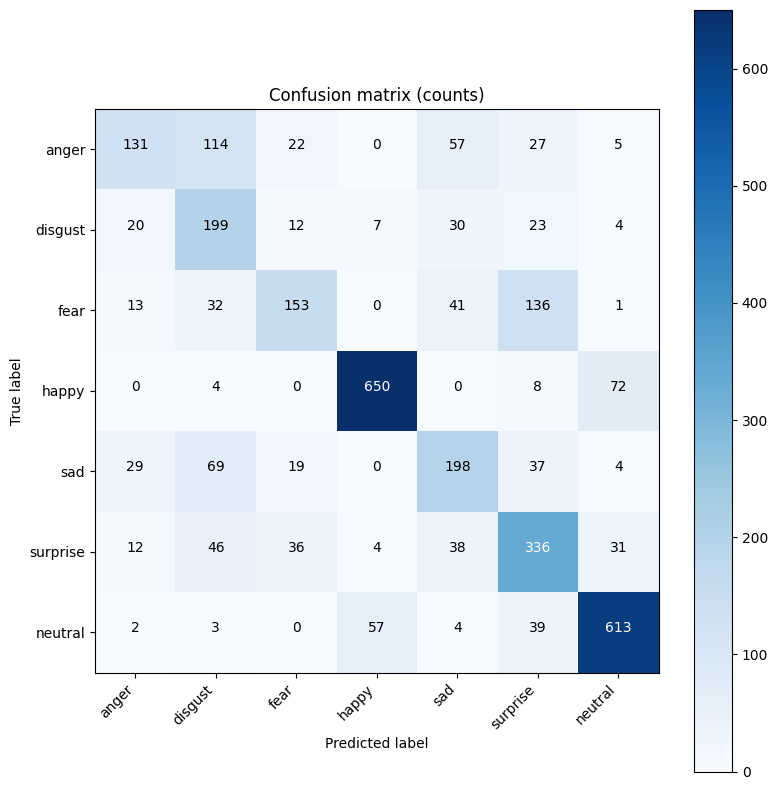

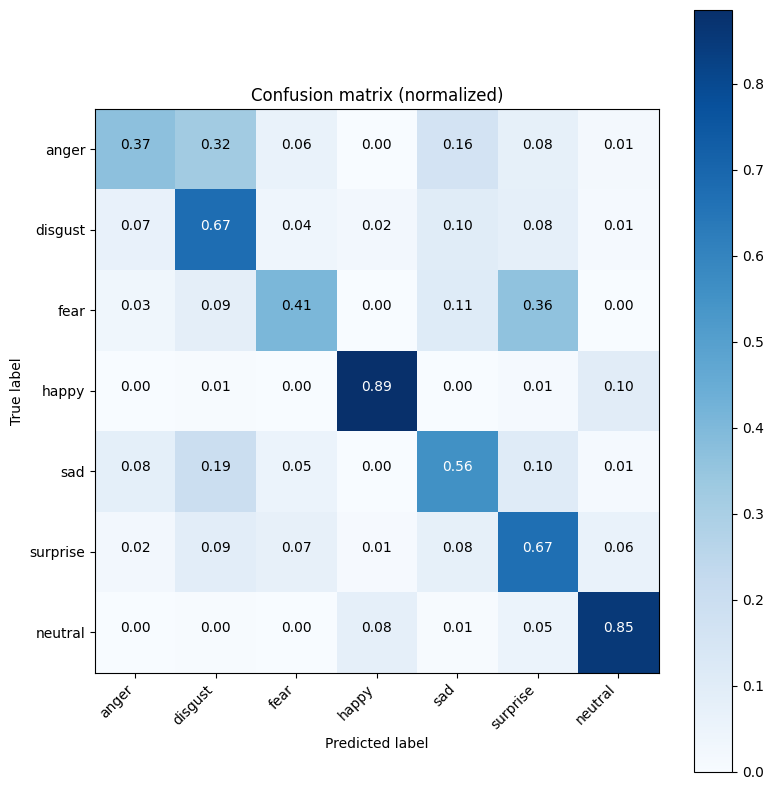

[INFO] Classification report:
              precision    recall  f1-score   support

       anger       0.63      0.37      0.47       356
     disgust       0.43      0.67      0.52       295
        fear       0.63      0.41      0.50       376
       happy       0.91      0.89      0.90       734
         sad       0.54      0.56      0.55       356
    surprise       0.55      0.67      0.61       503
     neutral       0.84      0.85      0.85       718

    accuracy                           0.68      3338
   macro avg       0.65      0.63      0.63      3338
weighted avg       0.70      0.68      0.68      3338


[INFO] Top confusing class pairs (true -> predicted):
       fear → surprise : 136 samples
      anger → disgust  : 114 samples
      happy → neutral  : 72 samples
        sad → disgust  : 69 samples
      anger → sad      : 57 samples
    neutral → happy    : 57 samples
   surprise → disgust  : 46 samples
       fear → sad      : 41 samples
    neutral → surprise : 39 

In [3]:

def main():
    # 3. Preprocess faces
    preprocess_all_faces(RAW_DATA_DIR, PROCESSED_DATA_DIR)

    # Create generators
    train_gen, val_gen, test_gen = create_datagen()

    # 4. Build model
    model, base_model = build_model()

    # 5–6. Train (frozen → fine-tune)
    hist1, hist2 = train_two_phase(model, base_model, train_gen, val_gen)

    # 7. Evaluate
    results = evaluate_model(model, test_gen)
    cm = results["cm"]

    # 8. Extra confusion analysis
    analyze_confusions(cm, CLASS_NAMES)

    # Save final model
    model.save("emotion_model_resnet50_mediapipe.h5")
    print("[INFO] Saved model to emotion_model_resnet50_mediapipe.h5")


if __name__ == "__main__":
    main()
